<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span><ul class="toc-item"><li><span><a href="#WARNINGS" data-toc-modified-id="WARNINGS-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>WARNINGS</a></span><ul class="toc-item"><li><span><a href="#Many-roads-to-Rome" data-toc-modified-id="Many-roads-to-Rome-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Many roads to Rome</a></span></li><li><span><a href="#'Heuristically'" data-toc-modified-id="'Heuristically'-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>'Heuristically'</a></span></li><li><span><a href="#Technically-possible-vs-practically-applicable" data-toc-modified-id="Technically-possible-vs-practically-applicable-1.1.3"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Technically possible vs practically applicable</a></span></li><li><span><a href="#Even-a-NN-needs-to-be-evaluated" data-toc-modified-id="Even-a-NN-needs-to-be-evaluated-1.1.4"><span class="toc-item-num">1.1.4&nbsp;&nbsp;</span>Even a NN needs to be evaluated</a></span></li><li><span><a href="#Keras-is-WIP" data-toc-modified-id="Keras-is-WIP-1.1.5"><span class="toc-item-num">1.1.5&nbsp;&nbsp;</span>Keras is WIP</a></span></li></ul></li></ul></li><li><span><a href="#Basic-overviews" data-toc-modified-id="Basic-overviews-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Basic overviews</a></span><ul class="toc-item"><li><span><a href="#General" data-toc-modified-id="General-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>General</a></span></li><li><span><a href="#Classification" data-toc-modified-id="Classification-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Classification</a></span></li><li><span><a href="#Regression" data-toc-modified-id="Regression-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Regression</a></span></li><li><span><a href="#Combinations" data-toc-modified-id="Combinations-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Combinations</a></span></li></ul></li><li><span><a href="#Imports" data-toc-modified-id="Imports-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Sequential-and-Non-Sequential-Neural-Nets" data-toc-modified-id="Sequential-and-Non-Sequential-Neural-Nets-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Sequential and Non Sequential Neural Nets</a></span><ul class="toc-item"><li><span><a href="#Setting-up-a-Sequential-NN-for-classification" data-toc-modified-id="Setting-up-a-Sequential-NN-for-classification-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Setting up a Sequential NN for classification</a></span><ul class="toc-item"><li><span><a href="#Get-data" data-toc-modified-id="Get-data-4.1.1"><span class="toc-item-num">4.1.1&nbsp;&nbsp;</span>Get data</a></span></li><li><span><a href="#Inspect-the-data" data-toc-modified-id="Inspect-the-data-4.1.2"><span class="toc-item-num">4.1.2&nbsp;&nbsp;</span>Inspect the data</a></span></li><li><span><a href="#Scale" data-toc-modified-id="Scale-4.1.3"><span class="toc-item-num">4.1.3&nbsp;&nbsp;</span>Scale</a></span></li><li><span><a href="#Creating-an-sequential-NN" data-toc-modified-id="Creating-an-sequential-NN-4.1.4"><span class="toc-item-num">4.1.4&nbsp;&nbsp;</span>Creating an sequential NN</a></span></li></ul></li><li><span><a href="#Dense-layer" data-toc-modified-id="Dense-layer-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Dense layer</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Many-roads-to-Rome..." data-toc-modified-id="Many-roads-to-Rome...-4.2.0.1"><span class="toc-item-num">4.2.0.1&nbsp;&nbsp;</span>Many roads to Rome...</a></span></li><li><span><a href="#Unlike-SkLearn..." data-toc-modified-id="Unlike-SkLearn...-4.2.0.2"><span class="toc-item-num">4.2.0.2&nbsp;&nbsp;</span>Unlike SkLearn...</a></span></li></ul></li><li><span><a href="#Fit" data-toc-modified-id="Fit-4.2.1"><span class="toc-item-num">4.2.1&nbsp;&nbsp;</span>Fit</a></span></li><li><span><a href="#Model-validation-on-Test" data-toc-modified-id="Model-validation-on-Test-4.2.2"><span class="toc-item-num">4.2.2&nbsp;&nbsp;</span>Model validation on Test</a></span></li><li><span><a href="#Predict" data-toc-modified-id="Predict-4.2.3"><span class="toc-item-num">4.2.3&nbsp;&nbsp;</span>Predict</a></span></li></ul></li><li><span><a href="#Setting-up-a-Sequential-NN-for-Regression" data-toc-modified-id="Setting-up-a-Sequential-NN-for-Regression-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Setting up a Sequential NN for Regression</a></span><ul class="toc-item"><li><span><a href="#Build-the-model" data-toc-modified-id="Build-the-model-4.3.1"><span class="toc-item-num">4.3.1&nbsp;&nbsp;</span>Build the model</a></span></li></ul></li></ul></li><li><span><a href="#Non-Sequential-Networks---functional-API" data-toc-modified-id="Non-Sequential-Networks---functional-API-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Non-Sequential Networks - functional API</a></span></li><li><span><a href="#Saving/Restoring-a-model" data-toc-modified-id="Saving/Restoring-a-model-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Saving/Restoring a model</a></span><ul class="toc-item"><li><span><a href="#Plain-Saving-and-Restoring" data-toc-modified-id="Plain-Saving-and-Restoring-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Plain Saving and Restoring</a></span></li><li><span><a href="#When-training-takes-hours:-Callbacks" data-toc-modified-id="When-training-takes-hours:-Callbacks-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>When training takes hours: Callbacks</a></span><ul class="toc-item"><li><span><a href="#Checkpoints" data-toc-modified-id="Checkpoints-6.2.1"><span class="toc-item-num">6.2.1&nbsp;&nbsp;</span>Checkpoints</a></span></li><li><span><a href="#Early-Stopping" data-toc-modified-id="Early-Stopping-6.2.2"><span class="toc-item-num">6.2.2&nbsp;&nbsp;</span>Early Stopping</a></span></li></ul></li></ul></li><li><span><a href="#Better-Models" data-toc-modified-id="Better-Models-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Better Models</a></span><ul class="toc-item"><li><span><a href="#Gridsearch" data-toc-modified-id="Gridsearch-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Gridsearch</a></span></li><li><span><a href="#Activation-function" data-toc-modified-id="Activation-function-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Activation function</a></span></li><li><span><a href="#Batch-Normalization" data-toc-modified-id="Batch-Normalization-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>Batch Normalization</a></span></li><li><span><a href="#Gradient-Clipping" data-toc-modified-id="Gradient-Clipping-7.4"><span class="toc-item-num">7.4&nbsp;&nbsp;</span>Gradient Clipping</a></span></li><li><span><a href="#Reusing-Pre-trained-Layers" data-toc-modified-id="Reusing-Pre-trained-Layers-7.5"><span class="toc-item-num">7.5&nbsp;&nbsp;</span>Reusing Pre-trained Layers</a></span></li><li><span><a href="#Regularization" data-toc-modified-id="Regularization-7.6"><span class="toc-item-num">7.6&nbsp;&nbsp;</span>Regularization</a></span></li><li><span><a href="#Drop-out" data-toc-modified-id="Drop-out-7.7"><span class="toc-item-num">7.7&nbsp;&nbsp;</span>Drop out</a></span></li><li><span><a href="#Better-cells" data-toc-modified-id="Better-cells-7.8"><span class="toc-item-num">7.8&nbsp;&nbsp;</span>Better cells</a></span><ul class="toc-item"><li><span><a href="#LSTM" data-toc-modified-id="LSTM-7.8.1"><span class="toc-item-num">7.8.1&nbsp;&nbsp;</span>LSTM</a></span></li><li><span><a href="#GRU" data-toc-modified-id="GRU-7.8.2"><span class="toc-item-num">7.8.2&nbsp;&nbsp;</span>GRU</a></span></li></ul></li></ul></li><li><span><a href="#Faster-Models" data-toc-modified-id="Faster-Models-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Faster Models</a></span><ul class="toc-item"><li><span><a href="#Faster-Optimizers" data-toc-modified-id="Faster-Optimizers-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Faster Optimizers</a></span></li><li><span><a href="#Learning-rate-scheduling" data-toc-modified-id="Learning-rate-scheduling-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>Learning rate scheduling</a></span><ul class="toc-item"><li><span><a href="#Power-Scheduling" data-toc-modified-id="Power-Scheduling-8.2.1"><span class="toc-item-num">8.2.1&nbsp;&nbsp;</span>Power Scheduling</a></span></li></ul></li><li><span><a href="#Loads-of-others" data-toc-modified-id="Loads-of-others-8.3"><span class="toc-item-num">8.3&nbsp;&nbsp;</span>Loads of others</a></span></li></ul></li><li><span><a href="#Appendix" data-toc-modified-id="Appendix-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Appendix</a></span><ul class="toc-item"><li><span><a href="#Scratch-pad" data-toc-modified-id="Scratch-pad-9.1"><span class="toc-item-num">9.1&nbsp;&nbsp;</span>Scratch pad</a></span></li></ul></li></ul></div>

# Artificial Neural Networks (ANN)

This is a personal summary of Aurélien Géron' s 'Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition' chapeters 10 and onwards.

<img src="https://learning.oreilly.com/library/cover/9781492032632/" />

Code adapted from:
https://github.com/ageron/handson-ml2/blob/master/10_neural_nets_with_keras.ipynb


This notebook assumes Neural Net basics are known


## Introduction
### WARNINGS
A couple of introductory remarks.

#### Many roads to Rome

It may be very confusing, even frustrating, to see that there are many ways to do things that are *all* valid. Input layers may be explicitly declared or be left implicit. Same is true for validation sets. One hot encoding may be done with Pandas (pd.get_dummies), sklearn.onehotencoder or keras.to_categorical.

What is good advice in this matter? Heuristically (see below) it is best to stick to the method provided by the library of the main model. E.g. If using a Keras NN, stick to keras.to_categorical for dummifying. Typically there are  implicit design assumptions across a library (at least one would hope). In this example pandas.get_dummies default for 'drop_first" is set to 'False' where Keras assumes 'True'. Within the Keras library this all hopefully aligns.

#### 'Heuristically'

'heuristically' is often a euphemism for 'trial and error' or, worse, 'this seems to work...but don't know why'.

Depending on the purpose of the model the level of 'heurism' may vary. If a model will be subject to external scrutiny stick to what you know, understand and can explain.

#### Technically possible vs practically applicable

These is a huge difference between what is technically possible and what may be applied an a actual dataset. Even in this book it is sometimes hard to see the practical applications of some of the examples.

#### Even a NN needs to be evaluated

It is very easy to get lost in extremely complex architectures, with niche Batch Normalization, custom Learning Rate Schedules, amongst countless others. It is important to remember that even a NN is a model that is fit(). Normal model score evaluations, like AUC, R2 and confusion matrices remain required. 

#### Keras is WIP

Who would dare call Keras/Tf a working prototype? In any event, it is very much WIP. There is constant development and keeping up is a day time job. Text pre-processing may serve as an example. Although it may be exciting to operate at the frontier being pushed forward be aware of the associated risks. There is no harm in sticking to the slightly more proven technologies

## Basic overviews

### General
The basic hyperparameters to set up any network for **any** problem:

Hyperparameter   |   Typical value
:--- |:--- |
No. Input Neurons | 1 per input feature (e.g. 28 x28 = 784 for MNST 
No. hidden layers | Depends on problem, typically 1 to 5</td>
No. Neurons or cells per hidden layers | Depend on the (complexity of) the problem, typically 10 to 100
No. output neurons | 1 per prediction dimension
Hidden Activation |Positive outputs: None or ReLU/Softplus/max. <br> Bounded outputs Sigmoid or Tanh
Loss Function | MSE or MAE/Huber(in case of outliers)

### Classification
Some additional for Classification problems:

Hyperparameter | Binary <br> Classification | Multi label binary <br> classification | Multi class <br> classification
---|---|---|--- |
Example | Spam: y/n | Spam: y/n *and* Urgent: y/n | choice of 1 classes
No. output neurons | 1 | 1 per label | 1 per class
Output layer activation | Logistic/sigmoid | Logistic/sigmoid | Logistic/sigmoid
Loss Function | Cross-entropy/<br>Log Loss | Cross-entropy/<br>Log Loss | Cross-entropy/<br>Log Loss

**Note** excludes multi-label multi-class, e.g. a romantic western comedy

### Regression

Hyperparameter | 1 target <br> variable | >1 target <br> variable
---|---|---
Example | House price | House price *and* <br> selling time 
No. output neurons | 1 | 1 per target 
Output layer | None | None 
Loss Function | MSE |MSE<br>may be specified per target

### Combinations

Since neural nets are specifically geared towards resolving complex patterns on large, if not huge, datasets, it is common for combinations of multiple targets to be trained in a single model. 

## Imports

In [13]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0-preview is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [1]:
import tensorflow as tf
from tensorflow import keras

In [2]:
tf.__version__

'2.0.0'

## Sequential and Non Sequential Neural Nets

The Keras library of essentially 2 model API's

1. Sequential API
All data flows from the input layer through the all hidden layers to the output layer.

2. Functional API
Essentially a DIY neural net where:
    - parts or all of the data 
    - may flow from one or multiple inputs 
    - to and/or from multiple hidden layers
    - to and ore from one or multiple outputs
    




### Setting up a Sequential NN for classification
#### Get data

In [88]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

#### Inspect the data

In [89]:
X_train_full.shape

(60000, 28, 28)

In [90]:
X_train_full.dtype

dtype('uint8')

Unscaled data

In [91]:
X_train_full[1][:1]#[1][:1] limitation for readability only

array([[  0,   0,   0,   0,   0,   1,   0,   0,   0,   0,  41, 188, 103,
         54,  48,  43,  87, 168, 133,  16,   0,   0,   0,   0,   0,   0,
          0,   0]], dtype=uint8)

#### Scale

In some rare cases scaling may not be required. However in a majority of the cases it **is**.
All sklearn scaling techniques are fine (sometime 0-1 scaling may be specifically required)

Below will work just as well:
> "Let's split the full training set into a validation set and a (smaller) training set. We also scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255."

Validation sets may be define specifically, but it is also possible at the time of fitting the model

In [92]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

scaled data

In [93]:
X_train[1][:1]#[1][:1] limitation for readability only

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.17254902, 0.21568627, 0.37647059,
        0.78823529, 0.1372549 , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.23529412, 0.72156863, 0.20784314,
        0.19607843, 0.06666667, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ]])

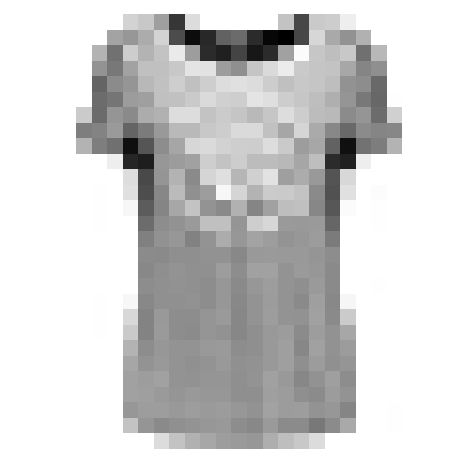

In [9]:
plt.imshow(X_train[1], cmap="binary")
plt.axis('off')
plt.show()

In [10]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

In [11]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

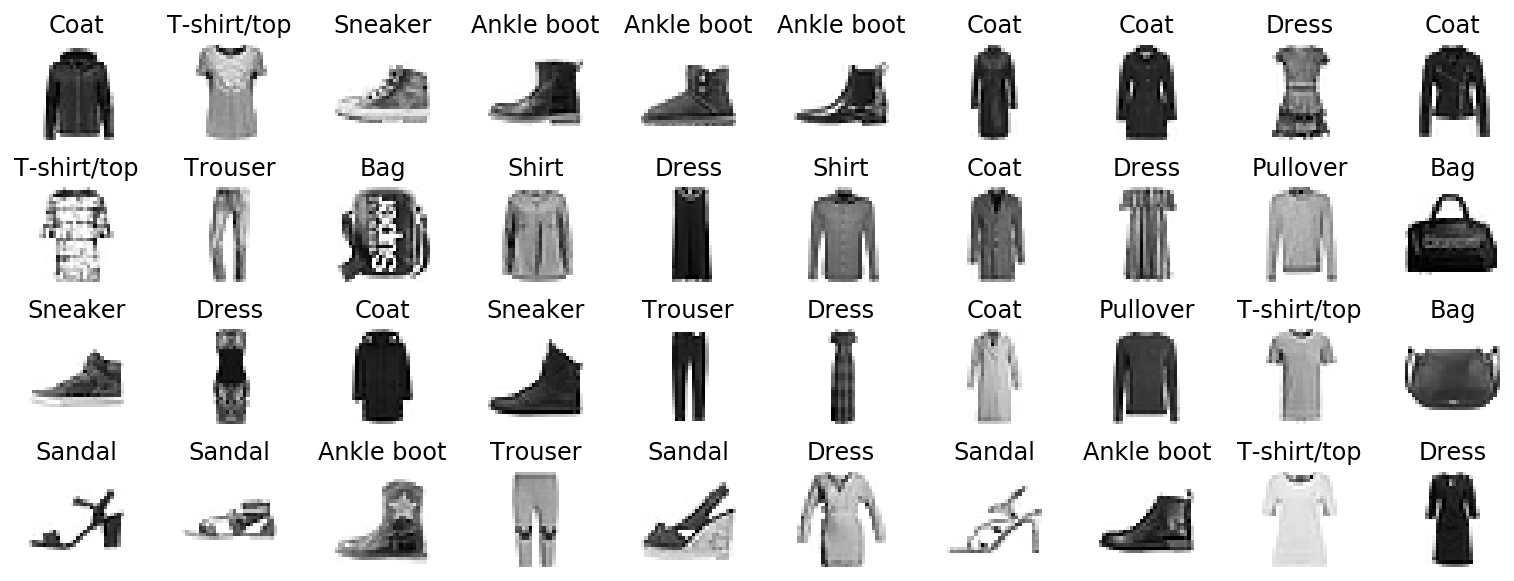

In [14]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
#save_fig('fashion_mnist_plot', tight_layout=False)
plt.show()

In [15]:
# Perfectly balanced
pd.Series(y_train_full).value_counts()#plot(kind='hist')

9    6000
8    6000
7    6000
6    6000
5    6000
4    6000
3    6000
2    6000
1    6000
0    6000
dtype: int64

#### Creating an sequential NN

The elegance of Keras is that you actually build the model by specifying the layers, inputs, outputs, connections, activation etc. It is *declarative*

Note: there is no data yet, just stating the network what to expect and what to do

In [19]:
#instanciate the model
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28])) # equal to X.reshape(-1,1)
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))


Since it is an object, it has some nifty functions

In [20]:
model.layers

### Dense layer

from: https://keras.io/layers/core/  

> Just your regular densely-connected NN layer.  
Dense implements the operation: output = activation(dot(input, kernel) + bias) where activation is the element-wise activation function passed as the activation argument, kernel is a weights matrix created by the layer, and bias is a bias vector created by the layer (only applicable if use_bias is True).

So, all this does is multiplying the input row with the (initially random) weights adding the biases, sum it and feed the value to the activation function to decide to fire a 0 or 1 to the cells in the next layer.


In [21]:
#In words
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 300)               235500    
_________________________________________________________________
dense_4 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


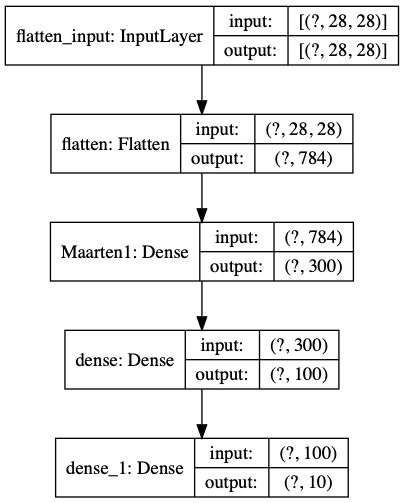

In [37]:
#In a picture
keras.utils.plot_model(model, "my_mnist_model.png", show_shapes=True)

##### Many roads to Rome...

Slightly different instantiations will work as well

In [23]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

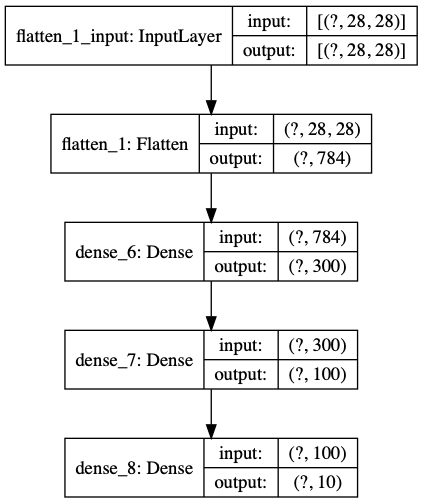

In [24]:
keras.utils.plot_model(model, "my_mnist_model.png", show_shapes=True)

In [25]:
weights, biases = model.layers[1].get_weights()
biases[:6]

array([0., 0., 0., 0., 0., 0.], dtype=float32)

##### Unlike SkLearn...

For loads of reasons Keras/tf does not 'reset' or overwrite an instantiated model object. It adds to it. The back-end needs to be actively reset.

In [26]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [27]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu", bias_initializer='RandomNormal', name = 'Maarten1'),#illustration
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
Maarten1 (Dense)             (None, 300)               235500    
_________________________________________________________________
dense (Dense)                (None, 100)               30100     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [29]:
weights, biases = model.layers[1].get_weights()

In [30]:
weights[0][:6]

array([ 0.02448617, -0.00877795, -0.02189048, -0.00528485, -0.06938942,
        0.02747849], dtype=float32)

In [31]:
weights.shape

(784, 300)

In [32]:
#effect of RandonNormal
biases[:6]

array([ 0.00421123, -0.04304519,  0.01890615, -0.00025981, -0.0247266 ,
        0.03089096], dtype=float32)

In [33]:
biases.shape

(300,)

In [34]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy", "sparse_categorical_accuracy" ])

Loss | classification problem | target vectors
--- | --- | ---
sparse_categorical_crossentropy | sparse labels, exclusive classes (probs add up to 1) | 1 each class own value
categorical_crossentropy | one-hot binary vectors for each class | each class own vector
binary cross entropy | 1 or many binary targets (**Use Softamx**) | 1 per target

In [35]:
# Many roads to rome
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=[keras.metrics.sparse_categorical_accuracy])

#### Fit

Handy features from the doc string:  
###### class_weight:   
Optional dictionary mapping class indices (integers)
        to a weight (float) value, used for weighting the loss function
        (during training only).
        This can be useful to tell the model to
        "pay more attention" to samples from
        an under-represented class.
###### validation_split:   
Float between 0 and 1.
        Fraction of the training data to be used as validation data.
        The model will set apart this fraction of the training data,
        will not train on it, and will evaluate
        the loss and any model metrics
        on this data at the end of each epoch.
        The validation data is selected from the last samples
        in the `x` and `y` data provided, before shuffling. This argument is
        not supported when `x` is a dataset, generator or
       `keras.utils.Sequence` instance.

In [36]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/30
55000/55000 [==============================] - 5s 86us/sample - loss: 0.7285 - sparse_categorical_accuracy: 0.7595 - val_loss: 0.5324 - val_sparse_categorical_accuracy: 0.8156
Epoch 2/30
55000/55000 [==============================] - 4s 81us/sample - loss: 0.4934 - sparse_categorical_accuracy: 0.8287 - val_loss: 0.4643 - val_sparse_categorical_accuracy: 0.8402
Epoch 3/30
55000/55000 [==============================] - 4s 82us/sample - loss: 0.4440 - sparse_categorical_accuracy: 0.8448 - val_loss: 0.4230 - val_sparse_categorical_accuracy: 0.8562
Epoch 4/30
55000/55000 [==============================] - 5s 82us/sample - loss: 0.4181 - sparse_categorical_accuracy: 0.8539 - val_loss: 0.3949 - val_sparse_categorical_accuracy: 0.8652
Epoch 5/30
55000/55000 [==============================] - 5s 86us/sample - loss: 0.3982 - sparse_categorical_accuracy: 0.8608 - val_loss: 0.4016 - val_sparse_categorical_accuracy: 0.8572
Epoch 6/30
55000

In [38]:
history.params

{'batch_size': 32,
 'epochs': 30,
 'steps': 1719,
 'samples': 55000,
 'verbose': 0,
 'do_validation': True,
 'metrics': ['loss',
  'sparse_categorical_accuracy',
  'val_loss',
  'val_sparse_categorical_accuracy']}

In [39]:
history.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])

In [40]:
pd.DataFrame(history.history).head()

,loss,sparse_categorical_accuracy,val_loss,val_sparse_categorical_accuracy
0,0.728514,0.759491,0.532440,0.8156
1,0.493362,0.828655,0.464254,0.8402
2,0.444000,0.844836,0.422985,0.8562
3,0.418089,0.853909,0.394864,0.8652
4,0.398168,0.860800,0.401557,0.8572


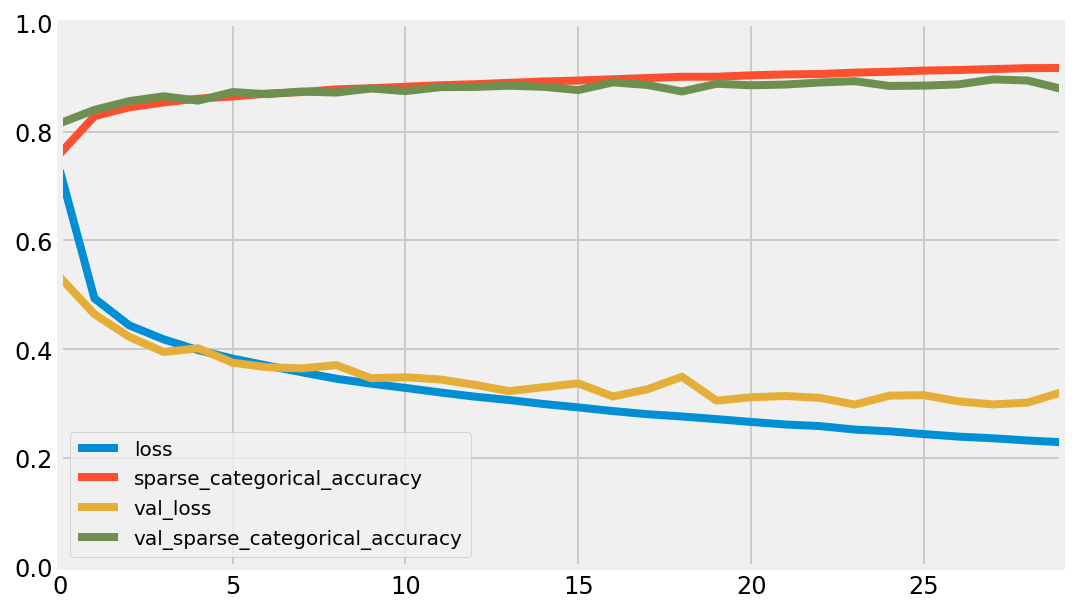

In [41]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
# save_fig("keras_learning_curves_plot")
plt.show()

#### Model validation on Test


In [42]:
model.evaluate(X_test, y_test, verbose = 0)

[0.3617307953596115, 0.8659]

> **All normal scoring and model tweaking should happen here**

#### Predict

In [43]:
#create some new data
X_new = X_test[:3]

y_proba = model.predict(X_new)
y_proba.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.01, 0.  , 0.97],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [44]:
y_pred = model.predict_classes(X_new)
y_pred

array([9, 2, 1])

In [45]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [46]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

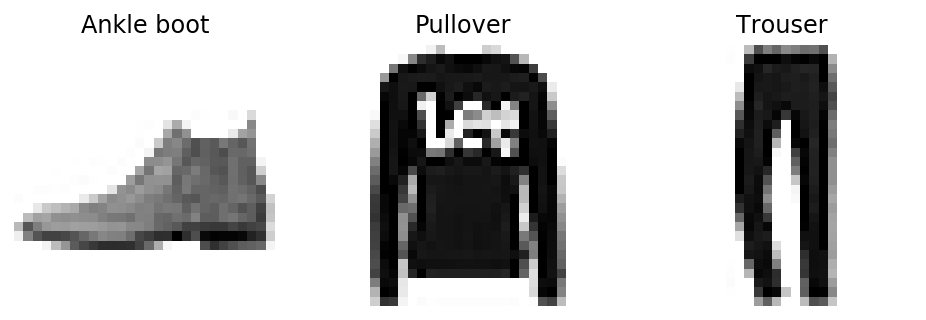

In [47]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
# save_fig('fashion_mnist_images_plot', tight_layout=False)
plt.show()

### Setting up a Sequential NN for Regression 

In [188]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [189]:
df = pd.DataFrame(housing['data'],
                      columns=housing['feature_names'])
df['ycol'] = housing['target']

In [190]:
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,ycol
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


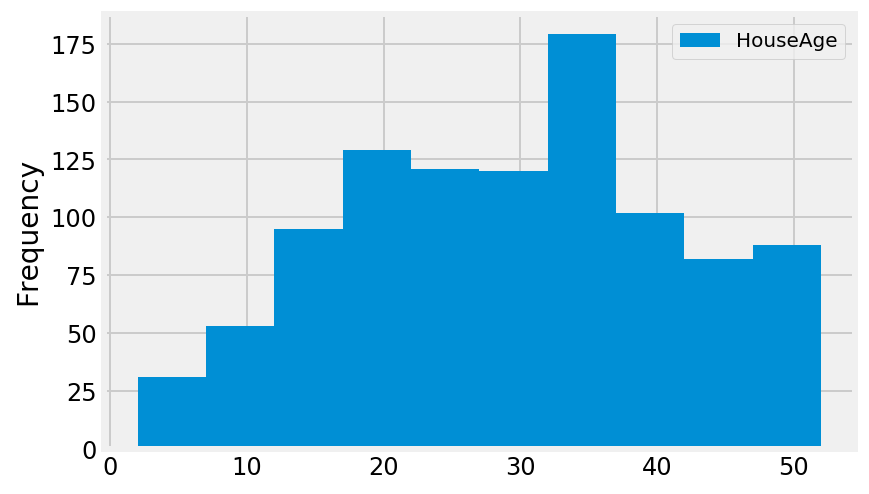

In [191]:
df[['HouseAge']].sample(1000).plot(kind='hist')

In [192]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [193]:
X_train.shape[1:] # the ':' creates a MANDATORY tuple

(8,)

#### Build the model

Setting up the architecture. Couple of observation:

- Simple problem so a single layer 
- Input layer is implicit
- Output is a **single** neuron with **no** activation. The target is a single continuous value and a activation in the sense of 'decision' is actually not wanted

In [194]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
    ])

In [195]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                270       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


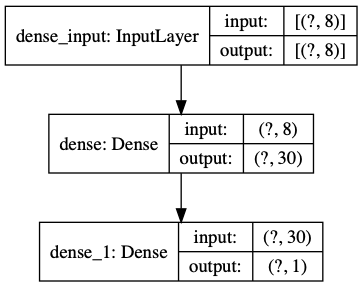

In [196]:
keras.utils.plot_model(model, show_shapes=True)

In [197]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=1e-3))

In [198]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 1s 90us/sample - loss: 1.6321 - val_loss: 1.5903
Epoch 2/20
11610/11610 [==============================] - 0s 37us/sample - loss: 0.7124 - val_loss: 0.6539
Epoch 3/20
11610/11610 [==============================] - 0s 37us/sample - loss: 0.6348 - val_loss: 0.6039
Epoch 4/20
11610/11610 [==============================] - 0s 37us/sample - loss: 0.5983 - val_loss: 0.5738
Epoch 5/20
11610/11610 [==============================] - 0s 37us/sample - loss: 0.5713 - val_loss: 0.5406
Epoch 6/20
11610/11610 [==============================] - 0s 36us/sample - loss: 0.5482 - val_loss: 0.5221
Epoch 7/20
11610/11610 [==============================] - 0s 37us/sample - loss: 0.5298 - val_loss: 0.4965
Epoch 8/20
11610/11610 [==============================] - 0s 37us/sample - loss: 0.5138 - val_loss: 0.4843
Epoch 9/20
11610/11610 [==============================] - 0s 37us/sample - loss: 0.5005 - val_l

In [199]:
mse_test = model.evaluate(X_test, y_test, verbose=0)
mse_test

0.4219739536906398

In [200]:
X_new = X_test[:3]
y_pred = model.predict(X_new)
y_pred

array([[0.36892918],
       [1.6819053 ],
       [3.0886497 ]], dtype=float32)

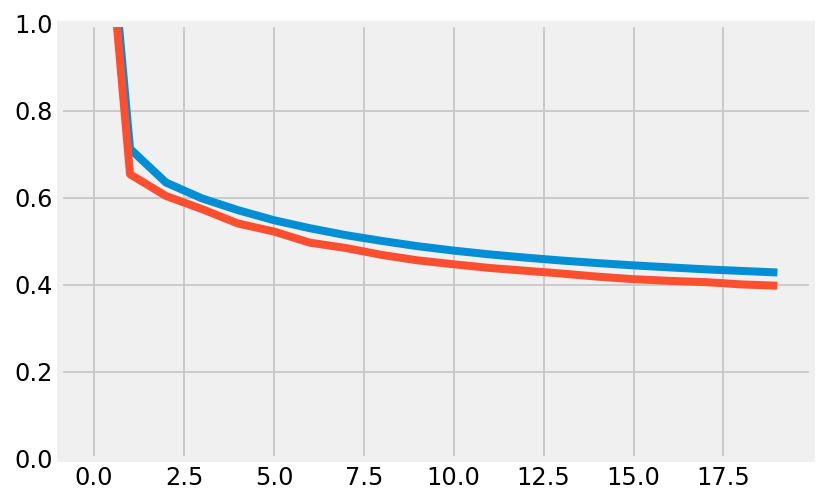

In [201]:
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [202]:
keras.layers.Input(shape=X_train.shape[1:])

<tf.Tensor 'input_1:0' shape=(None, 8) dtype=float32>

In [203]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

Explicit input layer

In [204]:
model = keras.models.Sequential([
    keras.layers.Input(shape=X_train.shape[1:]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
    ])

In [147]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                270       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


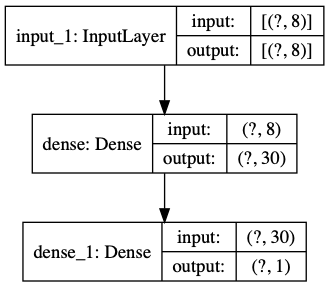

In [205]:
keras.utils.plot_model(model, show_shapes=True)

In [148]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=1e-3))

In [149]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 1s 57us/sample - loss: 1.6321 - val_loss: 1.5903
Epoch 2/20
11610/11610 [==============================] - 0s 36us/sample - loss: 0.7124 - val_loss: 0.6539
Epoch 3/20
11610/11610 [==============================] - 0s 35us/sample - loss: 0.6348 - val_loss: 0.6039
Epoch 4/20
11610/11610 [==============================] - 0s 36us/sample - loss: 0.5983 - val_loss: 0.5738
Epoch 5/20
11610/11610 [==============================] - 0s 35us/sample - loss: 0.5713 - val_loss: 0.5406
Epoch 6/20
11610/11610 [==============================] - 0s 35us/sample - loss: 0.5482 - val_loss: 0.5221
Epoch 7/20
11610/11610 [==============================] - 0s 36us/sample - loss: 0.5298 - val_loss: 0.4965
Epoch 8/20
11610/11610 [==============================] - 0s 35us/sample - loss: 0.5138 - val_loss: 0.4843
Epoch 9/20
11610/11610 [==============================] - 0s 36us/sample - loss: 0.5005 - val_l

In [150]:
mse_test = model.evaluate(X_test, y_test, verbose=0)

In [151]:
mse_test

0.4219739536906398

## Non-Sequential Networks - functional API

Forth coming

## Saving/Restoring a model

### Plain Saving and Restoring

In [207]:
model.save("my_keras_model.h5")

In [ ]:
model = keras.models.load_model("my_keras_model.h5")

In [208]:
model.predict(X_new)

array([[-0.13157476],
       [ 0.06550831],
       [ 1.0610095 ]], dtype=float32)

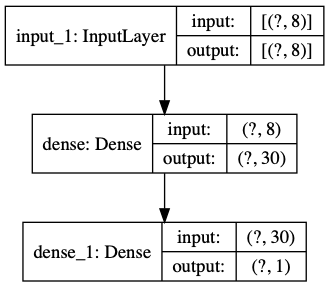

In [209]:
keras.utils.plot_model(model, show_shapes=True)

In [210]:
model.save_weights("my_keras_weights.ckpt")

In [211]:
model.save_weights("my_keras_weights.ckpt")

### When training takes hours: Callbacks

When training takes long it is wise to save intermediate results, which can be called later. 
> A computer always crashes at the wrong moment.

#### Checkpoints

Saving (all settings, i.e. weigths, biases, scores etc., of) a model at a set checkpoint. Default for each epoch, but batch is possible as well. It has a nifty feature 'save_best_only=True' which may be 'ab'-used to redefine the model with the settings that led to the best score. This is *not* gridsearching.

In [212]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [215]:
# compile model as normal
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

#create a check point
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)

#fit the model telling it to record the call backs
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb])
# rollback to best model
model = keras.models.load_model("my_keras_model.h5") 

#score  on the test set
mse_test = model.evaluate(X_test, y_test, verbose=0)

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 1s 59us/sample - loss: 0.4247 - val_loss: 0.3947
Epoch 2/10
11610/11610 [==============================] - 0s 40us/sample - loss: 0.4218 - val_loss: 0.3912
Epoch 3/10
11610/11610 [==============================] - 0s 39us/sample - loss: 0.4191 - val_loss: 0.3892
Epoch 4/10
11610/11610 [==============================] - 0s 38us/sample - loss: 0.4166 - val_loss: 0.3868
Epoch 5/10
11610/11610 [==============================] - 0s 38us/sample - loss: 0.4144 - val_loss: 0.3848
Epoch 6/10
11610/11610 [==============================] - 0s 40us/sample - loss: 0.4120 - val_loss: 0.3827
Epoch 7/10
11610/11610 [==============================] - 0s 37us/sample - loss: 0.4100 - val_loss: 0.3812
Epoch 8/10
11610/11610 [==============================] - 0s 37us/sample - loss: 0.4084 - val_loss: 0.3798
Epoch 9/10
11610/11610 [==============================] - 0s 37us/sample - loss: 0.4066 - val_l

#### Early Stopping

A logic that stops further training when no progress is made in improving scores for a set number of epochs.

This may be combined with a checkpoint with 'save_best_only=True' which automatically selects the best and stops automatically when it has reached a plateau.

> "The number of epochs can be set to a large value since training will stop automatically when there is no more progress. In this case, there is no need to restore the best model saved because the EarlyStopping callback will keep track of the best weights and restore them for you at the end of training."

In [216]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [218]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)

early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, #should be 10 illustration only
                                                  restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb])

mse_test = model.evaluate(X_test, y_test)

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 1s 58us/sample - loss: 0.3670 - val_loss: 0.3622
Epoch 2/100
11610/11610 [==============================] - 0s 40us/sample - loss: 0.3667 - val_loss: 0.3462
Epoch 3/100
11610/11610 [==============================] - 0s 40us/sample - loss: 0.3663 - val_loss: 0.3514
Epoch 4/100
11610/11610 [==============================] - 0s 38us/sample - loss: 0.3658 - val_loss: 0.3562
Epoch 5/100
11610/11610 [==============================] - 0s 36us/sample - loss: 0.3655 - val_loss: 0.3498
5160/1 [===================================================================================================================================================================================================================================================================================================================================================================================================================

## Better Models

### Gridsearch

Good old fashioned gridsearch is fine to find (some of) the best parameters for a model. Downside it if training NN's take long gridsearching  takes proportionally longer. Using RandomCV  or BayesSearchCV (Many more) is actually a very good idea.

In [222]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

Note: regressions example!

In [223]:
# function to build a model dynamically
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8]):
#input_shape=[8] I would say input_shape= X_train.shape[1:]    
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

In [224]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

In [225]:
keras_reg.fit(X_train, y_train, epochs=100,
              validation_data=(X_valid, y_valid),
              callbacks=[keras.callbacks.EarlyStopping(patience=3)]) # impatient setting

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 1s 57us/sample - loss: 1.1815 - val_loss: 20.7837
Epoch 2/100
11610/11610 [==============================] - 0s 36us/sample - loss: 0.7013 - val_loss: 0.6646
Epoch 3/100
11610/11610 [==============================] - 0s 36us/sample - loss: 0.5197 - val_loss: 0.5974
Epoch 4/100
11610/11610 [==============================] - 0s 36us/sample - loss: 0.4811 - val_loss: 0.5292
Epoch 5/100
11610/11610 [==============================] - 0s 36us/sample - loss: 0.4565 - val_loss: 0.4813
Epoch 6/100
11610/11610 [==============================] - 0s 36us/sample - loss: 0.4393 - val_loss: 0.4501
Epoch 7/100
11610/11610 [==============================] - 0s 36us/sample - loss: 0.4283 - val_loss: 0.4231
Epoch 8/100
11610/11610 [==============================] - 0s 36us/sample - loss: 0.4205 - val_loss: 0.4072
Epoch 9/100
11610/11610 [==============================] - 0s 36us/sample - loss: 0.41

In [227]:
mse_test = keras_reg.score(X_test, y_test, verbose=0)
mse_test

-0.37907314635524453

In [228]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100),
    "learning_rate": reciprocal(3e-4, 3e-2),
}

#very limited gridsearch to save time
rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=5, cv=2, verbose=2)
rnd_search_cv.fit(X_train, y_train, epochs=10,
                  validation_data=(X_valid, y_valid),
                  callbacks=[keras.callbacks.EarlyStopping(patience=3)])

Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV] learning_rate=0.001683454924600351, n_hidden=0, n_neurons=15 ....
Train on 5805 samples, validate on 3870 samples
Epoch 1/10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


5805/5805 [==============================] - 0s 83us/sample - loss: 3.4661 - val_loss: 8.5259
Epoch 2/10
5805/5805 [==============================] - 0s 43us/sample - loss: 1.3620 - val_loss: 9.7888
Epoch 3/10
5805/5805 [==============================] - 0s 42us/sample - loss: 0.7553 - val_loss: 11.5583
Epoch 4/10
5805/5805 [==============================] - 0s 42us/sample - loss: 0.5740 - val_loss: 13.3903
5805/1 [=====================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[CV]  learning_rate=0.001683454924600351, n_hidden=0, n_neurons=15, total=   1.4s
[CV] learning_rate=0.001683454924600351, n_hidden=0, n_neurons=15 ....
Train on 5805 samples, validate on 3870 samples
Epoch 1/10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


5805/5805 [==============================] - 0s 79us/sample - loss: 3.5950 - val_loss: 2.0594
Epoch 2/10
5805/5805 [==============================] - 0s 44us/sample - loss: 1.5575 - val_loss: 1.0573
Epoch 3/10
5805/5805 [==============================] - 0s 42us/sample - loss: 0.9514 - val_loss: 0.7620
Epoch 4/10
5805/5805 [==============================] - 0s 42us/sample - loss: 0.7602 - val_loss: 0.7220
Epoch 5/10
5805/5805 [==============================] - 0s 43us/sample - loss: 0.6900 - val_loss: 0.7903
Epoch 6/10
5805/5805 [==============================] - 0s 46us/sample - loss: 0.6633 - val_loss: 0.7137
Epoch 7/10
5805/5805 [==============================] - 0s 46us/sample - loss: 0.6473 - val_loss: 0.6245
Epoch 8/10
5805/5805 [==============================] - 0s 44us/sample - loss: 0.6346 - val_loss: 0.6040
Epoch 9/10
5805/5805 [==============================] - 0s 42us/sample - loss: 0.6247 - val_loss: 0.6458
Epoch 10/10
5805/5805 [==============================] - 0s 43us/s

[CV]  learning_rate=0.001683454924600351, n_hidden=0, n_neurons=15, total=   2.9s
[CV] learning_rate=0.008731907739399206, n_hidden=0, n_neurons=21 ....
Train on 5805 samples, validate on 3870 samples
Epoch 1/10
5805/5805 [==============================] - 0s 78us/sample - loss: 1.3218 - val_loss: 36.6309
Epoch 2/10
5805/5805 [==============================] - 0s 43us/sample - loss: 0.5185 - val_loss: 39.9084
Epoch 3/10
5805/5805 [==============================] - 0s 43us/sample - loss: 0.5048 - val_loss: 42.9963
Epoch 4/10
5805/5805 [==============================] - 0s 42us/sample - loss: 0.4968 - val_loss: 45.0024
5805/1 [===============================================================================================================================================================================================================================================================================================================================================================================

[CV]  learning_rate=0.008731907739399206, n_hidden=0, n_neurons=21, total=   1.4s
[CV] learning_rate=0.008731907739399206, n_hidden=0, n_neurons=21 ....
Train on 5805 samples, validate on 3870 samples
Epoch 1/10
5805/5805 [==============================] - 0s 82us/sample - loss: 1.7289 - val_loss: 54.1819
Epoch 2/10
5805/5805 [==============================] - 0s 44us/sample - loss: 1.6385 - val_loss: 248.1922
Epoch 3/10
5805/5805 [==============================] - 0s 44us/sample - loss: 1.3994 - val_loss: 364.8735
Epoch 4/10
5805/5805 [==============================] - 0s 47us/sample - loss: 4.1271 - val_loss: 1001.4235
5805/1 [===========================================================================================================================================================================================================================================================================================================================================================================

[CV]  learning_rate=0.008731907739399206, n_hidden=0, n_neurons=21, total=   1.8s
[CV] learning_rate=0.0006154014789262348, n_hidden=2, n_neurons=87 ...
Train on 5805 samples, validate on 3870 samples
Epoch 1/10
5805/5805 [==============================] - 1s 95us/sample - loss: 2.7493 - val_loss: 6.0610
Epoch 2/10
5805/5805 [==============================] - 0s 50us/sample - loss: 1.2309 - val_loss: 7.1730
Epoch 3/10
5805/5805 [==============================] - 0s 48us/sample - loss: 0.9414 - val_loss: 6.2459
Epoch 4/10
5805/5805 [==============================] - 0s 54us/sample - loss: 0.8258 - val_loss: 4.9374
Epoch 5/10
5805/5805 [==============================] - 0s 53us/sample - loss: 0.7596 - val_loss: 3.8416
Epoch 6/10
5805/5805 [==============================] - 0s 53us/sample - loss: 0.7154 - val_loss: 3.1020
Epoch 7/10
5805/5805 [==============================] - 0s 54us/sample - loss: 0.6837 - val_loss: 2.4263
Epoch 8/10
5805/5805 [==============================] - 0s 53us/

[CV]  learning_rate=0.0006154014789262348, n_hidden=2, n_neurons=87, total=   3.5s
[CV] learning_rate=0.0006154014789262348, n_hidden=2, n_neurons=87 ...
Train on 5805 samples, validate on 3870 samples
Epoch 1/10
5805/5805 [==============================] - 1s 98us/sample - loss: 3.3653 - val_loss: 7.0043
Epoch 2/10
5805/5805 [==============================] - 0s 54us/sample - loss: 1.4381 - val_loss: 1.7105
Epoch 3/10
5805/5805 [==============================] - 0s 53us/sample - loss: 0.8696 - val_loss: 0.9117
Epoch 4/10
5805/5805 [==============================] - 0s 48us/sample - loss: 0.7298 - val_loss: 0.7215
Epoch 5/10
5805/5805 [==============================] - 0s 60us/sample - loss: 0.6786 - val_loss: 0.6643
Epoch 6/10
5805/5805 [==============================] - 0s 49us/sample - loss: 0.6485 - val_loss: 0.6271
Epoch 7/10
5805/5805 [==============================] - 0s 58us/sample - loss: 0.6267 - val_loss: 0.6148
Epoch 8/10
5805/5805 [==============================] - 0s 58us

[CV]  learning_rate=0.0006154014789262348, n_hidden=2, n_neurons=87, total=   3.6s
[CV] learning_rate=0.0003920021771415983, n_hidden=3, n_neurons=24 ...
Train on 5805 samples, validate on 3870 samples
Epoch 1/10
5805/5805 [==============================] - 1s 104us/sample - loss: 3.4328 - val_loss: 3.8939
Epoch 2/10
5805/5805 [==============================] - 0s 58us/sample - loss: 1.6868 - val_loss: 3.6734
Epoch 3/10
5805/5805 [==============================] - 0s 48us/sample - loss: 1.0006 - val_loss: 3.7657
Epoch 4/10
5805/5805 [==============================] - 0s 51us/sample - loss: 0.8286 - val_loss: 3.6837
Epoch 5/10
5805/5805 [==============================] - 0s 47us/sample - loss: 0.7654 - val_loss: 3.5150
Epoch 6/10
5805/5805 [==============================] - 0s 47us/sample - loss: 0.7252 - val_loss: 3.3723
Epoch 7/10
5805/5805 [==============================] - 0s 46us/sample - loss: 0.6969 - val_loss: 3.2217
Epoch 8/10
5805/5805 [==============================] - 0s 46u

[CV]  learning_rate=0.0003920021771415983, n_hidden=3, n_neurons=24, total=   3.4s
[CV] learning_rate=0.0003920021771415983, n_hidden=3, n_neurons=24 ...
Train on 5805 samples, validate on 3870 samples
Epoch 1/10
5805/5805 [==============================] - 1s 98us/sample - loss: 3.2722 - val_loss: 8.7406
Epoch 2/10
5805/5805 [==============================] - 0s 46us/sample - loss: 1.6431 - val_loss: 4.4414
Epoch 3/10
5805/5805 [==============================] - 0s 46us/sample - loss: 1.0172 - val_loss: 3.0497
Epoch 4/10
5805/5805 [==============================] - 0s 47us/sample - loss: 0.8123 - val_loss: 1.8852
Epoch 5/10
5805/5805 [==============================] - 0s 48us/sample - loss: 0.7232 - val_loss: 1.1970
Epoch 6/10
5805/5805 [==============================] - 0s 50us/sample - loss: 0.6759 - val_loss: 0.8378
Epoch 7/10
5805/5805 [==============================] - 0s 48us/sample - loss: 0.6486 - val_loss: 0.7191
Epoch 8/10
5805/5805 [==============================] - 0s 51us

[CV]  learning_rate=0.0003920021771415983, n_hidden=3, n_neurons=24, total=   3.3s
[CV] learning_rate=0.006010328378268217, n_hidden=0, n_neurons=2 .....
Train on 5805 samples, validate on 3870 samples
Epoch 1/10
5805/5805 [==============================] - 0s 83us/sample - loss: 2.3093 - val_loss: 2.1477
Epoch 2/10
5805/5805 [==============================] - 0s 45us/sample - loss: 0.7326 - val_loss: 1.2893
Epoch 3/10
5805/5805 [==============================] - 0s 49us/sample - loss: 0.6380 - val_loss: 6.0315
Epoch 4/10
5805/5805 [==============================] - 0s 47us/sample - loss: 0.5870 - val_loss: 12.7097
Epoch 5/10
5805/5805 [==============================] - 0s 44us/sample - loss: 0.5532 - val_loss: 19.2688
5805/1 [=======================================================================================================================================================================================================================================================================

[CV]  learning_rate=0.006010328378268217, n_hidden=0, n_neurons=2, total=   2.1s
[CV] learning_rate=0.006010328378268217, n_hidden=0, n_neurons=2 .....
Train on 5805 samples, validate on 3870 samples
Epoch 1/10
5805/5805 [==============================] - 0s 83us/sample - loss: 2.5629 - val_loss: 103.5535
Epoch 2/10
5805/5805 [==============================] - 0s 43us/sample - loss: 2.0690 - val_loss: 231.6678
Epoch 3/10
5805/5805 [==============================] - 0s 42us/sample - loss: 1.8939 - val_loss: 298.2524
Epoch 4/10
5805/5805 [==============================] - 0s 42us/sample - loss: 3.7901 - val_loss: 534.1425
5805/1 [============================================================================================================================================================================================================================================================================================================================================================================

[CV]  learning_rate=0.006010328378268217, n_hidden=0, n_neurons=2, total=   1.4s
Train on 11610 samples, validate on 3870 samples
Epoch 1/10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   24.8s finished


11610/11610 [==============================] - 1s 63us/sample - loss: 2.3212 - val_loss: 2.7807
Epoch 2/10
11610/11610 [==============================] - 0s 38us/sample - loss: 0.8545 - val_loss: 0.8955
Epoch 3/10
11610/11610 [==============================] - 0s 38us/sample - loss: 0.7112 - val_loss: 0.6582
Epoch 4/10
11610/11610 [==============================] - 0s 38us/sample - loss: 0.6564 - val_loss: 0.6113
Epoch 5/10
11610/11610 [==============================] - 0s 38us/sample - loss: 0.6204 - val_loss: 0.5797
Epoch 6/10
11610/11610 [==============================] - 0s 41us/sample - loss: 0.5906 - val_loss: 0.5638
Epoch 7/10
11610/11610 [==============================] - 0s 38us/sample - loss: 0.5650 - val_loss: 0.5332
Epoch 8/10
11610/11610 [==============================] - 0s 38us/sample - loss: 0.5434 - val_loss: 0.5155
Epoch 9/10
11610/11610 [==============================] - 0s 38us/sample - loss: 0.5241 - val_loss: 0.4907
Epoch 10/10
11610/11610 [=======================

RandomizedSearchCV(cv=2, error_score='raise-deprecating',
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x1a3f3bb8d0>,
                   iid='warn', n_iter=5, n_jobs=None,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a3f768518>,
                                        'n_hidden': [0, 1, 2, 3],
                                        'n_neurons': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12...
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_tr

In [229]:
rnd_search_cv.best_params_

{'learning_rate': 0.0006154014789262348, 'n_hidden': 2, 'n_neurons': 87}

In [230]:
rnd_search_cv.best_score_

-0.5968685511496434

In [231]:
rnd_search_cv.best_estimator_

In [235]:
score = rnd_search_cv.score(X_test, y_test)
score

5160/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

-0.48943254513333934

In [236]:
model = rnd_search_cv.best_estimator_.model
model


In [237]:
model.evaluate(X_test, y_test)

5160/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.48943254513333934

### Activation function

In plain terms the activation is the decision function that determines whether a unit fires 0 or 1 to the next layer. Plain sigmoid (logistic) has the disadvantage of a vanishing gradient  close to 0, 1 and exploding gradient around 0.5. This is what Aurélien says about it:

> "So, which activation function should you use for the hidden layers of your deep neural networks? Although your mileage will vary, in general SELU > ELU > leaky ReLU (and its variants) > ReLU > tanh > logistic. If the network’s architecture prevents it from self-normalizing, then ELU may perform better than SELU (since SELU is not smooth at z = 0). If you care a lot about runtime latency, then you may prefer leaky ReLU. If you don’t want to tweak yet another hyperparameter, you may use the default α values used by Keras (e.g., 0.3 for leaky ReLU). If you have spare time and computing power, you can use cross-validation to evaluate other activation functions, such as RReLU if your network is overfitting or PReLU if you have a huge training set. That said, because ReLU is the most used activation function (by far), many libraries and hardware accelerators provide ReLU-specific optimizations; therefore, if speed is your priority, ReLU might still be the best choice."

### Batch Normalization

Where activation may solving the vanishing gradient descent initially Batch Normalization suppresses it coming back.

> "The technique consists of adding an operation in the model just before or after the activation function of each hidden layer. This operation simply zero-centers and normalizes each input, then scales and shifts the result using two new parameter vectors per layer: one for scaling, the other for shifting. In other words, the operation lets the model learn the optimal scale and mean of each of the layer’s inputs. In many cases, if you add a BN layer as the very first layer of your neural network, you do not need to standardize your training set (e.g., using a StandardScaler)"

> "Ioffe and Szegedy demonstrated that Batch Normalization considerably improved all the deep neural networks they experimented with, leading to a huge improvement in the ImageNet classification task (ImageNet is a large database of images classified into many classes, commonly used to evaluate computer vision systems). The vanishing gradients problem was strongly reduced, to the point that they could use saturating activation functions such as the tanh and even the logistic activation function. The networks were also much less sensitive to the weight initialization. The authors were able to use much larger learning rates, significantly speeding up the learning process. Specifically, they note that:
>> '*Applied to a state-of-the-art image classification model, Batch Normalization achieves the same accuracy with 14 times fewer training steps, and beats the original model by a significant margin. […] Using an ensemble of batch-normalized networks, we improve upon the best published result on ImageNet classification: reaching 4.9% top-5 validation error (and 4.8% test error), exceeding the accuracy of human raters.*'

> Finally, like a gift that keeps on giving, Batch Normalization acts like a regularizer, reducing the need for other regularization techniques (such as dropout, described later in this chapter).

**Note** Batch normalisation is tricky in RNN's, use Gradient Clipping instead

In [238]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

In [239]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense_25 (Dense)             (None, 300)               235500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_26 (Dense)             (None, 100)               30100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_27 (Dense)             (None, 10)              

### Gradient Clipping

In [241]:
optimizer = keras.optimizers.SGD(clipvalue=1.0)

In [242]:
optimizer = keras.optimizers.SGD(clipnorm=1.0)

### Reusing Pre-trained Layers

Check the book, too complex for a summary

### Regularization



In [ ]:
layer = keras.layers.Dense(100, activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))
# or l1(0.1) for ℓ1 regularization with a factor or 0.1
# or l1_l2(0.1, 0.01) for both ℓ1 and ℓ2 regularization, 
#with factors 0.1 and 0.01 respectively

If applying regularization all layers should be the same. To avoid errors the 'partial' function may work well

In [ ]:
from functools import partial

RegularizedDense = partial(keras.layers.Dense,
                           activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

### Drop out



In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

### Better cells

#### LSTM

>page 515: If you consider the LSTM cell as a black box, it can be used very much like a basic cell, except it will perform much better; training will converge faster, and it will detect long-term dependencies in the data.

In [102]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [82]:
model = keras.models.Sequential([
#     keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.LSTM(300,return_sequences=True, input_shape=[28,28,]),
    keras.layers.LSTM(100),
    keras.layers.Dense(10, activation="softmax")
])

In [83]:
model.input.shape

TensorShape([None, 28, 28])

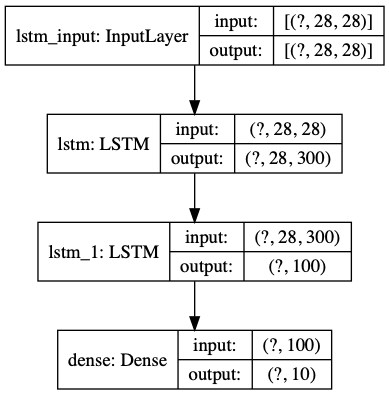

In [84]:
keras.utils.plot_model(model, show_shapes=True)

In [98]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=['accuracy'])

In [99]:

checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)

early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, #should be 10 illustration only
                                                  restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb])

mse_test = model.evaluate(X_test, y_test)

Train on 55000 samples, validate on 5000 samples
Epoch 1/100
55000/55000 [==============================] - 153s 3ms/sample - loss: 0.5452 - accuracy: 0.7945 - val_loss: 0.4140 - val_accuracy: 0.8406
Epoch 2/100
55000/55000 [==============================] - 165s 3ms/sample - loss: 0.3892 - accuracy: 0.8556 - val_loss: 0.3747 - val_accuracy: 0.8562
Epoch 3/100
55000/55000 [==============================] - 152s 3ms/sample - loss: 0.3429 - accuracy: 0.8727 - val_loss: 0.3293 - val_accuracy: 0.8786
Epoch 4/100
55000/55000 [==============================] - 167s 3ms/sample - loss: 0.3089 - accuracy: 0.8846 - val_loss: 0.2979 - val_accuracy: 0.8900
Epoch 5/100
55000/55000 [==============================] - 154s 3ms/sample - loss: 0.2832 - accuracy: 0.8948 - val_loss: 0.2894 - val_accuracy: 0.8950
Epoch 6/100
55000/55000 [==============================] - 162s 3ms/sample - loss: 0.2638 - accuracy: 0.9017 - val_loss: 0.2764 - val_accuracy: 0.8984
Epoch 7/100
55000/55000 [====================

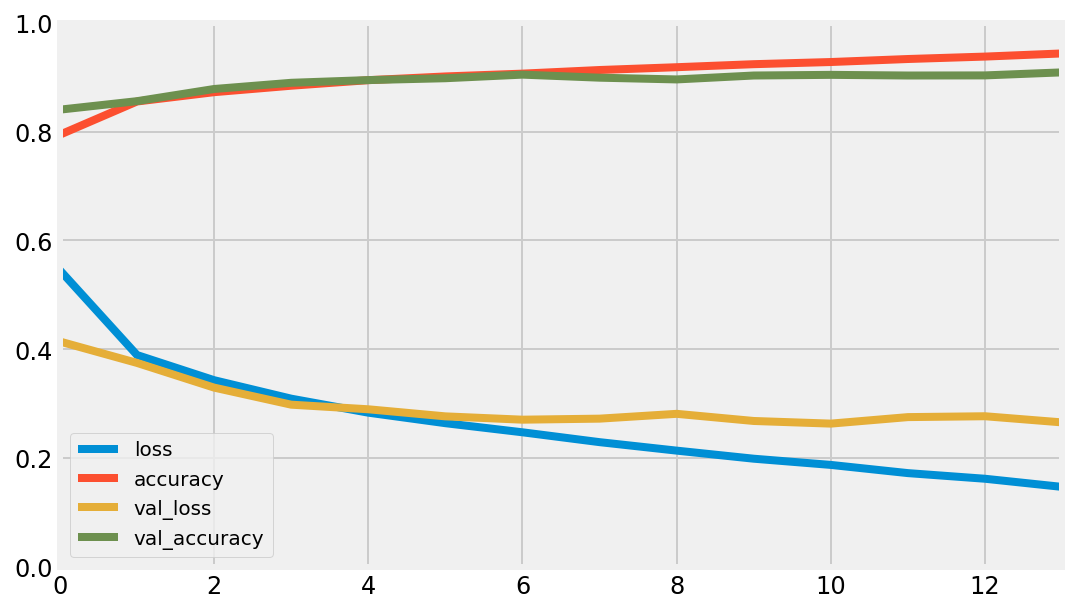

In [100]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
# save_fig("keras_learning_curves_plot")
plt.show()

In [101]:
model.evaluate(X_test, y_test, verbose = 0)
# Accuracy just Dense 0.86

[0.27965735642910006, 0.902]

#### GRU



In [103]:
model = keras.models.Sequential([
#     keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.GRU(300,return_sequences=True, input_shape=[28,28,]),
    keras.layers.GRU(100),
    keras.layers.Dense(10, activation="softmax")
])

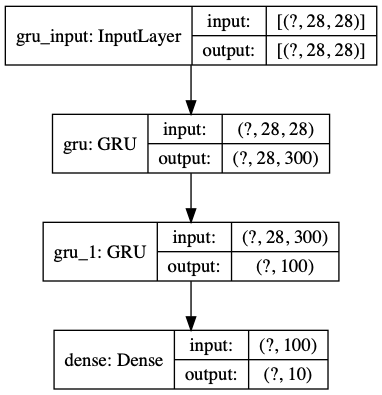

In [104]:
keras.utils.plot_model(model, show_shapes=True)

In [105]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=['accuracy'])

In [106]:

checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)

early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, #should be 10 illustration only
                                                  restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb])

mse_test = model.evaluate(X_test, y_test)

Train on 55000 samples, validate on 5000 samples
Epoch 1/100
55000/55000 [==============================] - 142s 3ms/sample - loss: 0.5462 - accuracy: 0.7973 - val_loss: 0.3704 - val_accuracy: 0.8660
Epoch 2/100
55000/55000 [==============================] - 128s 2ms/sample - loss: 0.3614 - accuracy: 0.8666 - val_loss: 0.3290 - val_accuracy: 0.8736
Epoch 3/100
55000/55000 [==============================] - 127s 2ms/sample - loss: 0.3056 - accuracy: 0.8871 - val_loss: 0.2972 - val_accuracy: 0.8924
Epoch 4/100
55000/55000 [==============================] - 119s 2ms/sample - loss: 0.2710 - accuracy: 0.8979 - val_loss: 0.2635 - val_accuracy: 0.9040
Epoch 5/100
55000/55000 [==============================] - 120s 2ms/sample - loss: 0.2434 - accuracy: 0.9082 - val_loss: 0.2731 - val_accuracy: 0.9048
Epoch 6/100
55000/55000 [==============================] - 119s 2ms/sample - loss: 0.2216 - accuracy: 0.9164 - val_loss: 0.2571 - val_accuracy: 0.9080
Epoch 7/100
55000/55000 [====================

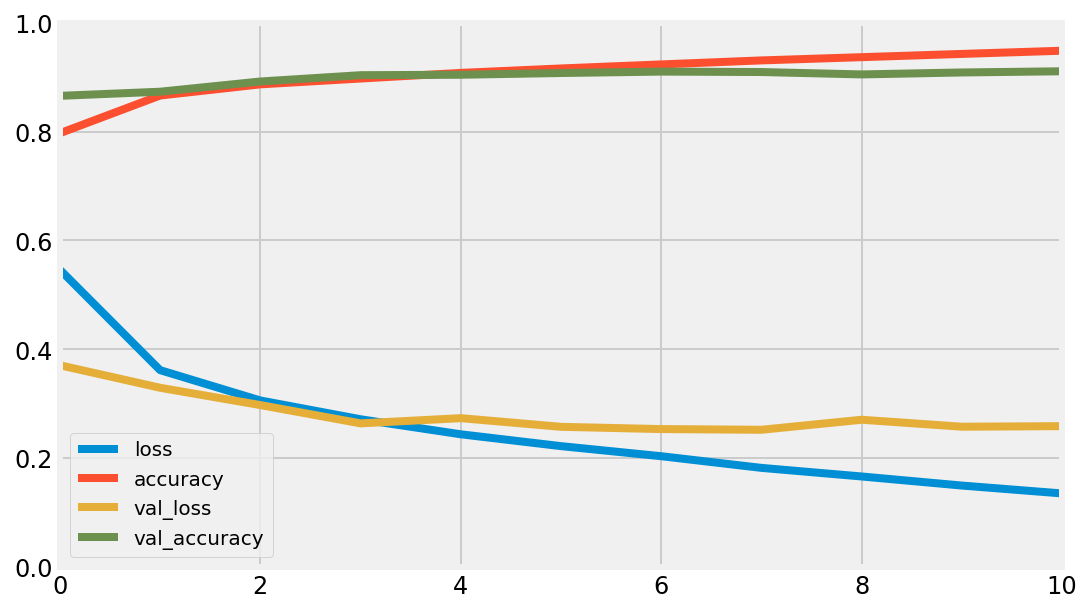

In [107]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
# save_fig("keras_learning_curves_plot")
plt.show()

In [108]:
model.evaluate(X_test, y_test, verbose = 0)

# Dense .86, LSTM 0.902

[0.28223297452330587, 0.9007]

## Faster Models

### Faster Optimizers

| Class                            | Convergence <br>speed | Convergence <br>quality |
|----------------------------------|-------------------|---------------------|
| SGD                              | *                 | ***                 |
| SGD(momentum=...)                | **                | ***                 |
| SGD(momentum=..., nesterov=True) | **                | ***                 |
| Adagrad                          | ***               | * (stops too early) |
| RMSprop                          | ***               | ** or ***           |
| Adam                             | ***               | ** or ***           |
| Nadam                            | ***               | ** or ***           |
| AdaMax                           | ***               | ** or ***           ||

In [240]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9)

In [ ]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)

In [ ]:
optimizer = keras.optimizers.Adagrad(lr=0.001)

In [ ]:
optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9)

In [ ]:
optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

In [ ]:
optimizer = keras.optimizers.Adamax(lr=0.001, beta_1=0.9, beta_2=0.999)

In [ ]:
optimizer = keras.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999)

### Learning rate scheduling

A flat learning rate is not very clever. Where big learning steps are fine in the initial stages, close to convergence smaller learning steps are better, this avoids overshooting.

#### Power Scheduling

Easiest

lr = lr0 / (1 + steps / s)\\**\\ c
Keras uses c=1 and s = 1 / decay

In [ ]:
optimizer = keras.optimizers.SGD(lr=0.01, decay=1e-4)

### Loads of others

Check the book

## Appendix

In [2]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

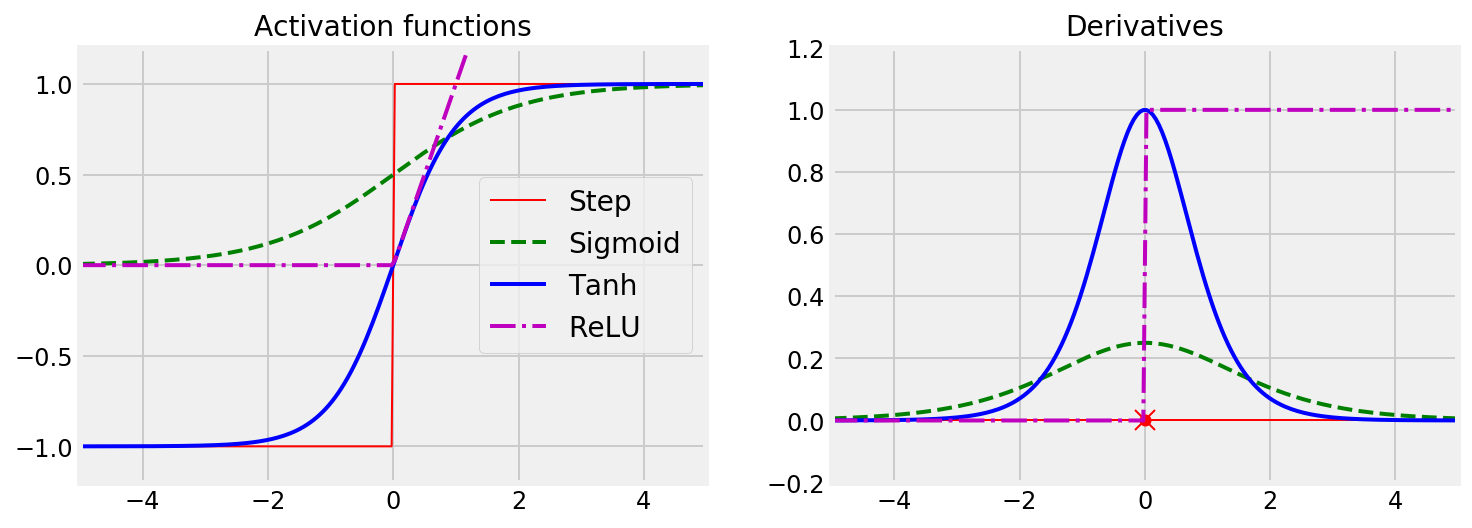

In [3]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=1, label="Step")
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=1, label="Step")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
#plt.legend(loc="center right", fontsize=14)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

# save_fig("activation_functions_plot")
plt.show()

In [4]:
def heaviside(z):
    return (z >= 0).astype(z.dtype)

def mlp_xor(x1, x2, activation=heaviside):
    return activation(-activation(x1 + x2 - 1.5) + activation(x1 + x2 - 0.5) - 0.5)

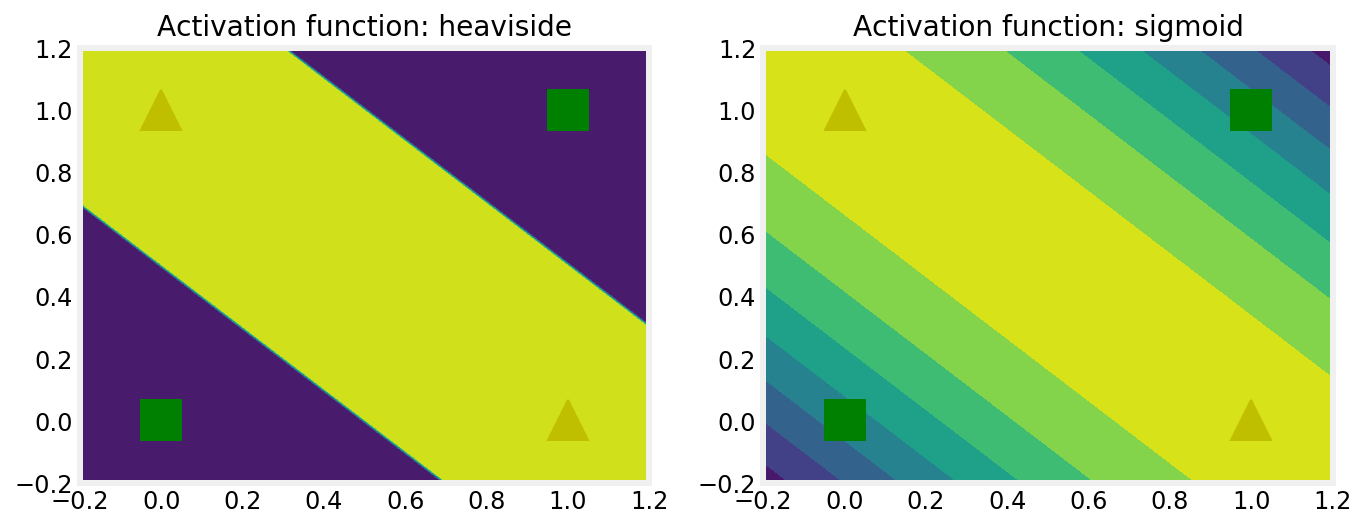

In [5]:
x1s = np.linspace(-0.2, 1.2, 100)
x2s = np.linspace(-0.2, 1.2, 100)
x1, x2 = np.meshgrid(x1s, x2s)

z1 = mlp_xor(x1, x2, activation=heaviside)
z2 = mlp_xor(x1, x2, activation=sigmoid)

plt.figure(figsize=(10,4))

plt.subplot(121)
plt.contourf(x1, x2, z1)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: heaviside", fontsize=14)
plt.grid(True)

plt.subplot(122)
plt.contourf(x1, x2, z2)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: sigmoid", fontsize=14)
plt.grid(True)


In [244]:
def logit(z):
    return 1 / (1 + np.exp(-z))

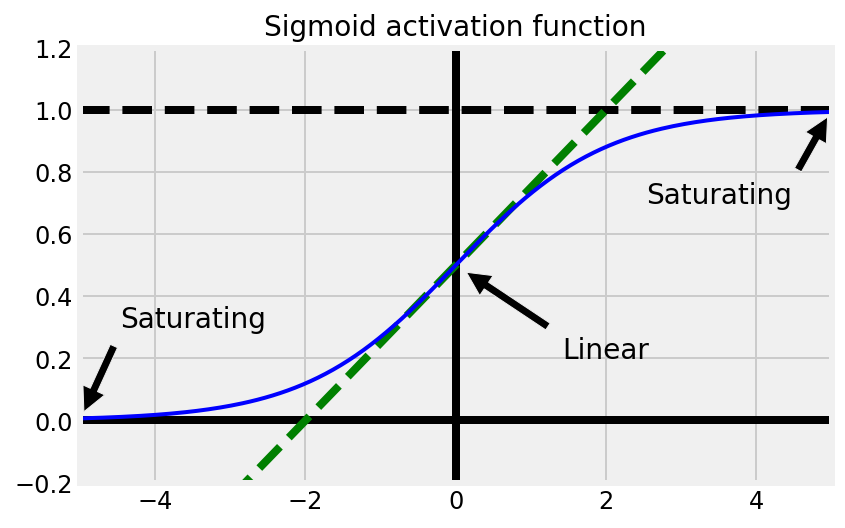

In [245]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

# save_fig("sigmoid_saturation_plot")
plt.show()

In [246]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

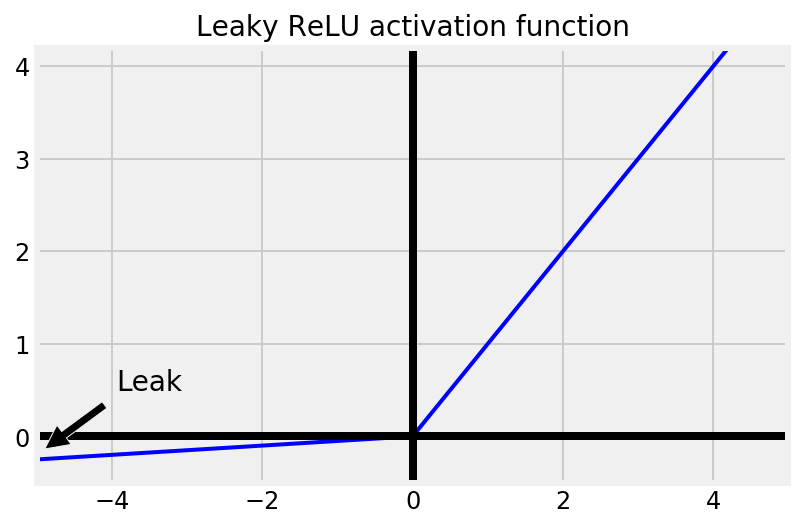

In [247]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

# save_fig("leaky_relu_plot")
plt.show()

In [248]:
[m for m in dir(keras.activations) if not m.startswith("_")]

['deserialize',
 'elu',
 'exponential',
 'get',
 'hard_sigmoid',
 'linear',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'tanh']

In [249]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

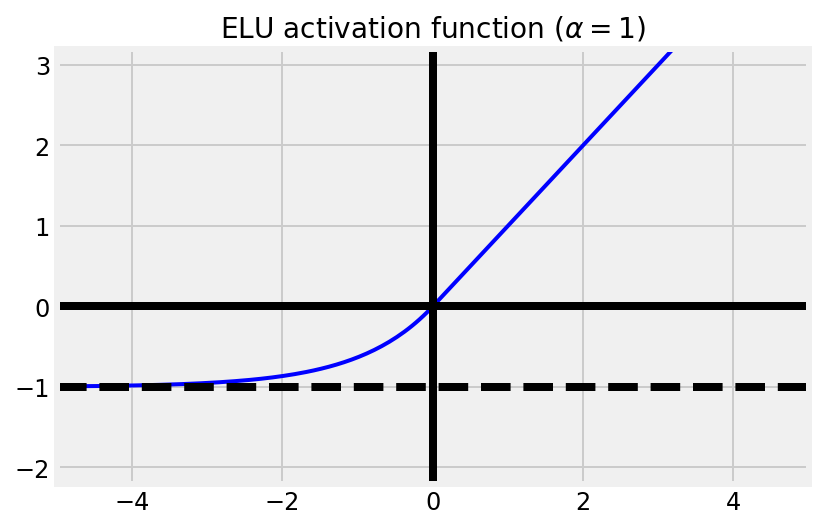

In [251]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

# save_fig("elu_plot")
plt.show()

In [259]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * \
(2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*\
 erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

Saving figure selu_plot


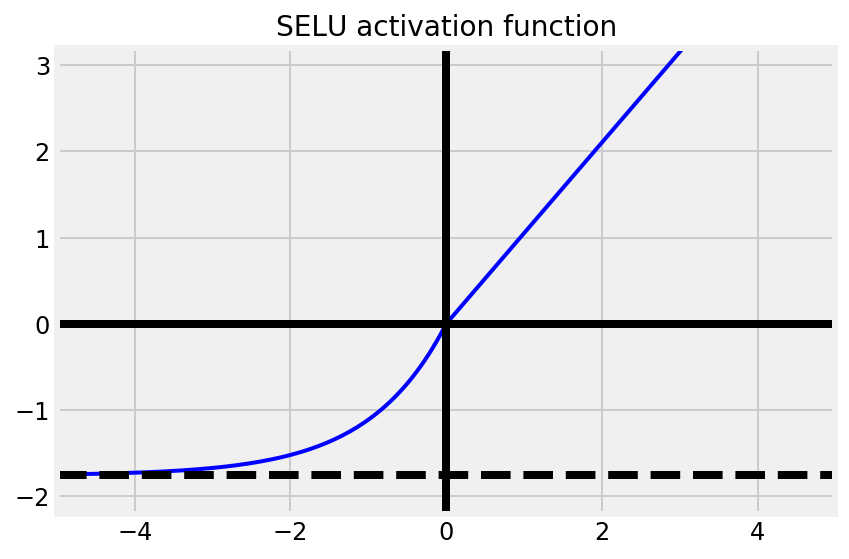

In [260]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("selu_plot")
plt.show()

<img src="https://www.asimovinstitute.org/wp-content/uploads/2019/04/NeuralNetworkZoo20042019.png" />

### Scratch pad

In [ ]:
https://stackoverflow.com/questions/52486088/dont-understand-how-to-implement-embeddings-for-categorical-features
    

In [ ]:
numerical_df = pd.DataFrame(np.random.randint(0,100,size=(100, 3)), columns=['num_1','num_2','num_3'])

cat_df = pd.DataFrame(np.random.randint(0,5,size=(100, 3)), columns=['cat_1','cat_2','cat_3'])

df = numerical_df.join(cat_df)

numerical_in = Input(shape=(3,))
cat_in       = Input(shape=(3,))
embed_layer  = Embedding(input_dim=5, output_dim=3, input_length=3)(cat_in)
embed_layer  = Flatten(embed_layer)
merged_layer = concatenate([numerical_in, embed_layer])
output       = rest_of_your_model(merged_layer)
model        = Model(inputs=[numerical_in, cat_in], outputs=[output])

...

model.fit(x=[numerical_df, cat_df], y=[your_expected_out])